# Выбор локации для скважины

Допустим, мы работаем в добывающей компании. Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Условия:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.


## Загрузка и подготовка данных

### Импортируем библиотеки

In [140]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from scipy import stats as st
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

warnings.filterwarnings("ignore")

### Загружаем и изучаем данные датасетов

In [141]:
try:
    reg_1 = pd.read_csv('geo_data_0.csv')
except:
    reg_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')

In [142]:
try:
    reg_2 = pd.read_csv('geo_data_1.csv')
except:
    reg_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')

In [143]:
try:
    reg_3 = pd.read_csv('geo_data_2.csv')
except:
    reg_3 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

In [144]:
print(reg_1.info())
reg_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


В данных первого региона пропусков нет.

In [145]:
print(reg_2.info())
reg_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


В данных второго региона пропусков нет.

In [146]:
print(reg_3.info())
reg_3.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


В данных третьего региона пропусков нет.

### Общая информация, уникальные значения и дубликаты

In [147]:
reg_1.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


In [148]:
reg_2.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


In [149]:
reg_3.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


Так как три признака (f0, f1, f2) не описаны, мы не можем описать важность минимальных, максимальных, средних и других значений.

In [150]:
print('Дубликаты Региона 1:', reg_1.duplicated().sum())
print('Дубликаты Региона 2:', reg_2.duplicated().sum())
print('Дубликаты Региона 3:', reg_3.duplicated().sum())

Дубликаты Региона 1: 0
Дубликаты Региона 2: 0
Дубликаты Региона 3: 0


In [151]:
print('Уникальные значения Региона 1:')
reg_1.nunique()

Уникальные значения Региона 1:


id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

In [152]:
print('Уникальные значения Региона 2:')
reg_2.nunique()

Уникальные значения Региона 2:


id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64

In [153]:
print('Уникальные значения Региона 3:')
reg_3.nunique()

Уникальные значения Региона 3:


id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

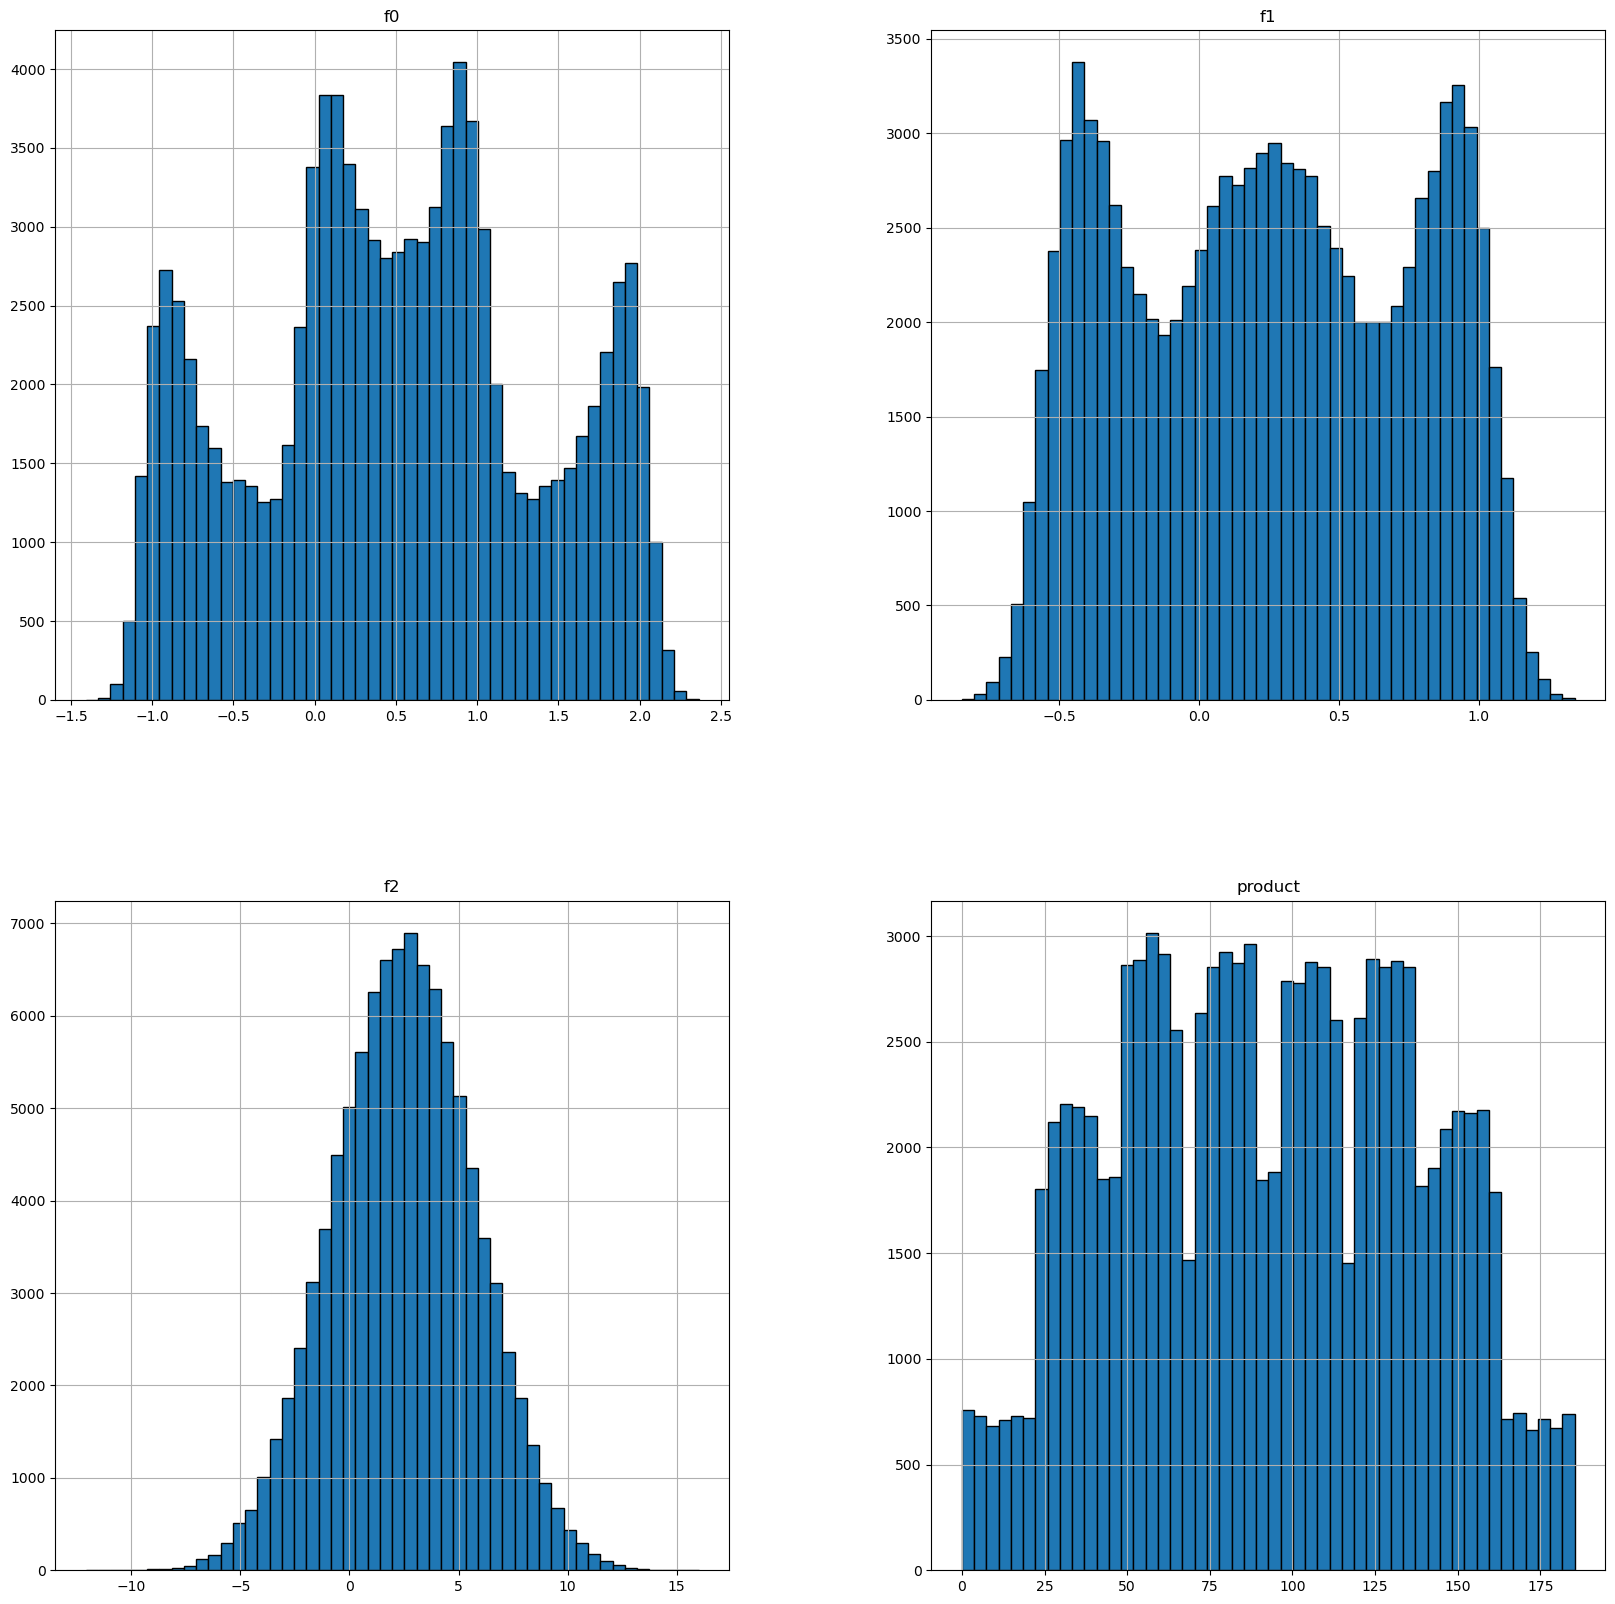

In [154]:
reg_1.hist(bins=50, figsize=(20, 20), edgecolor='black');

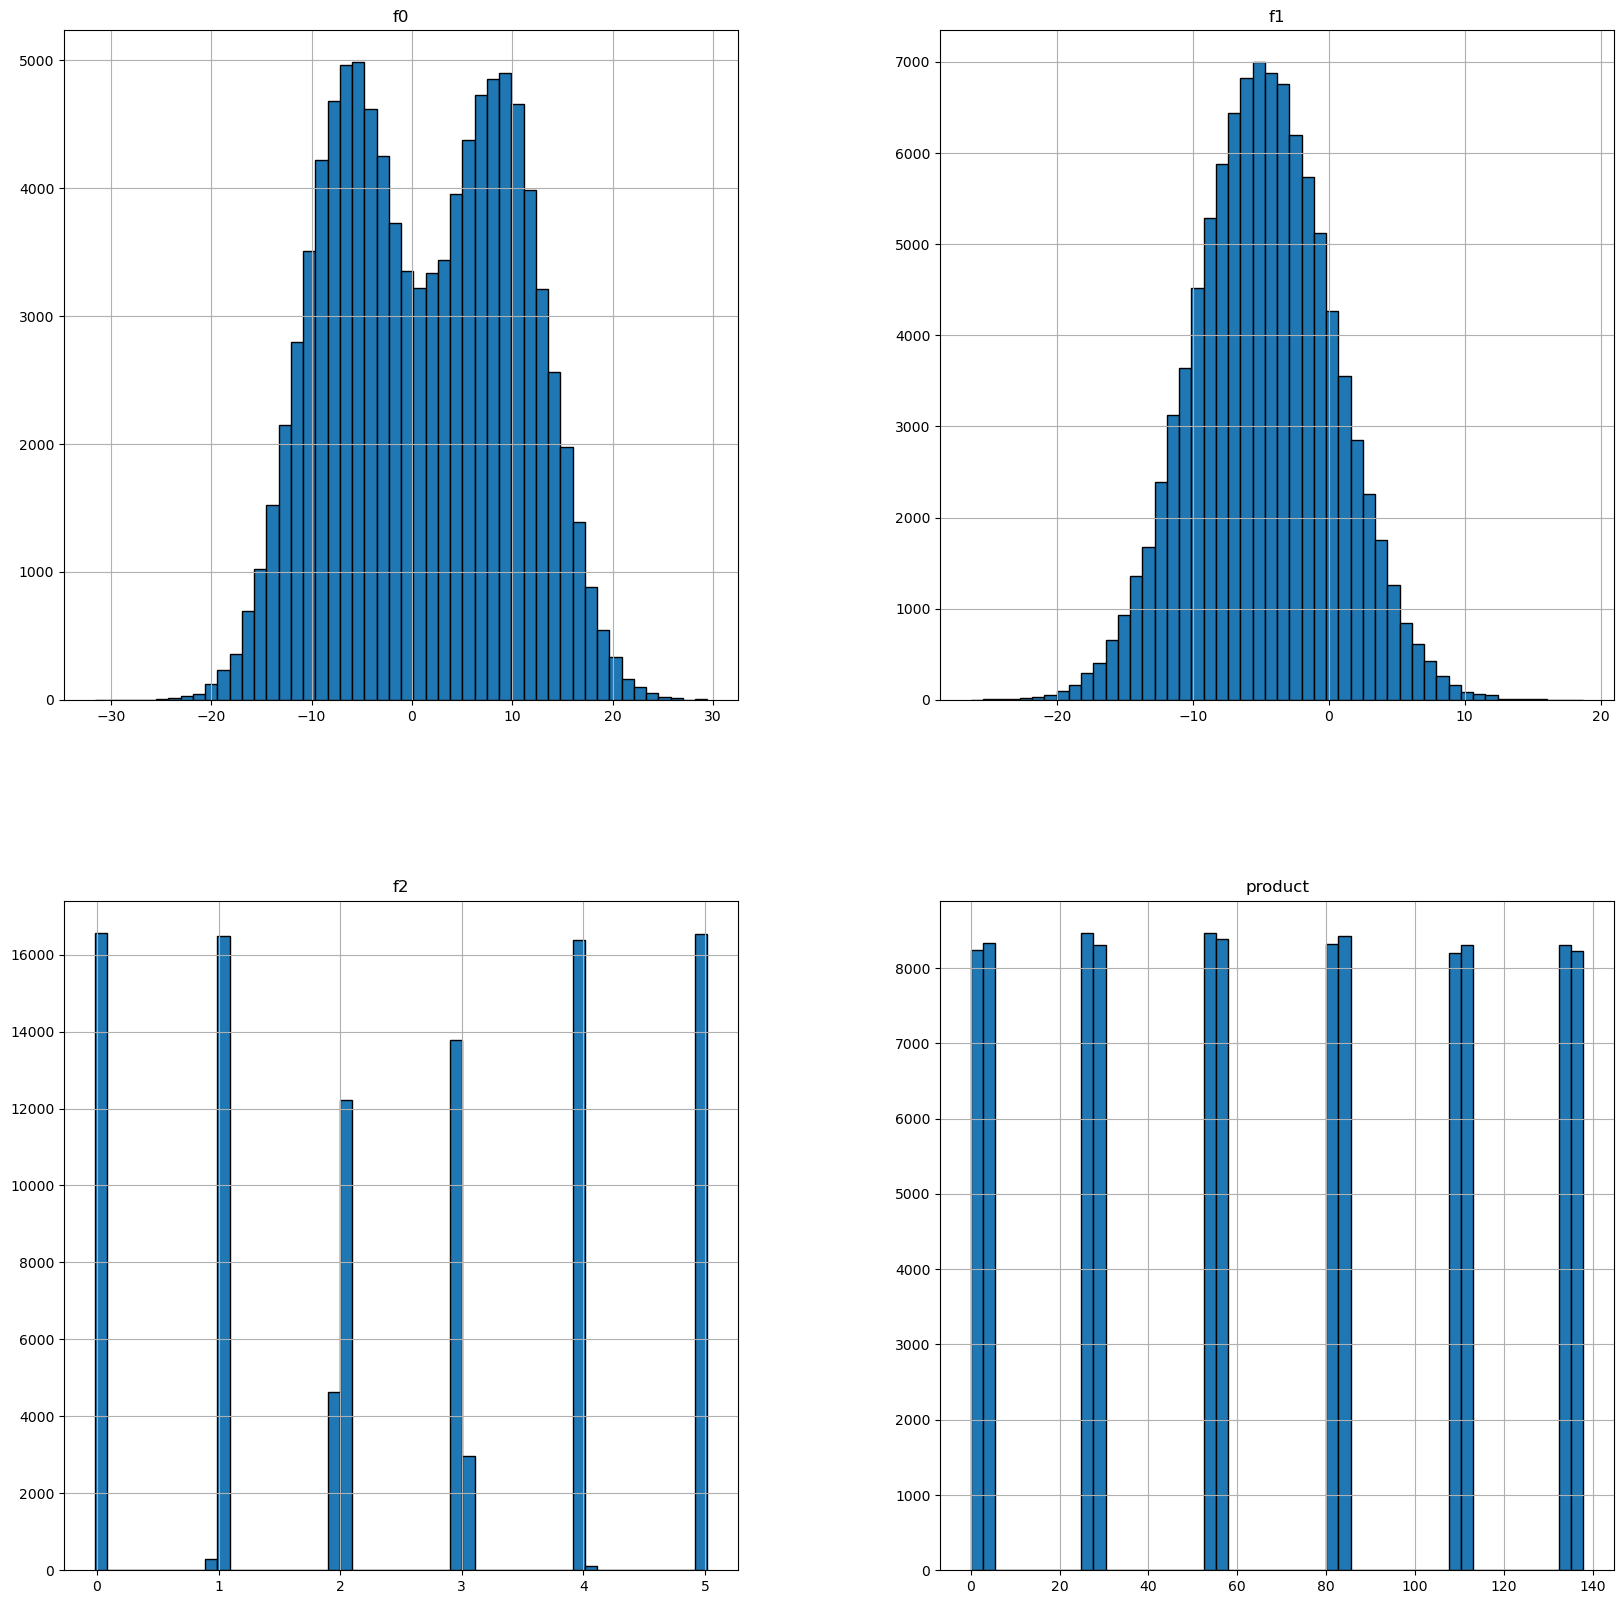

In [155]:
reg_2.hist(bins=50, figsize=(20, 20), edgecolor='black');

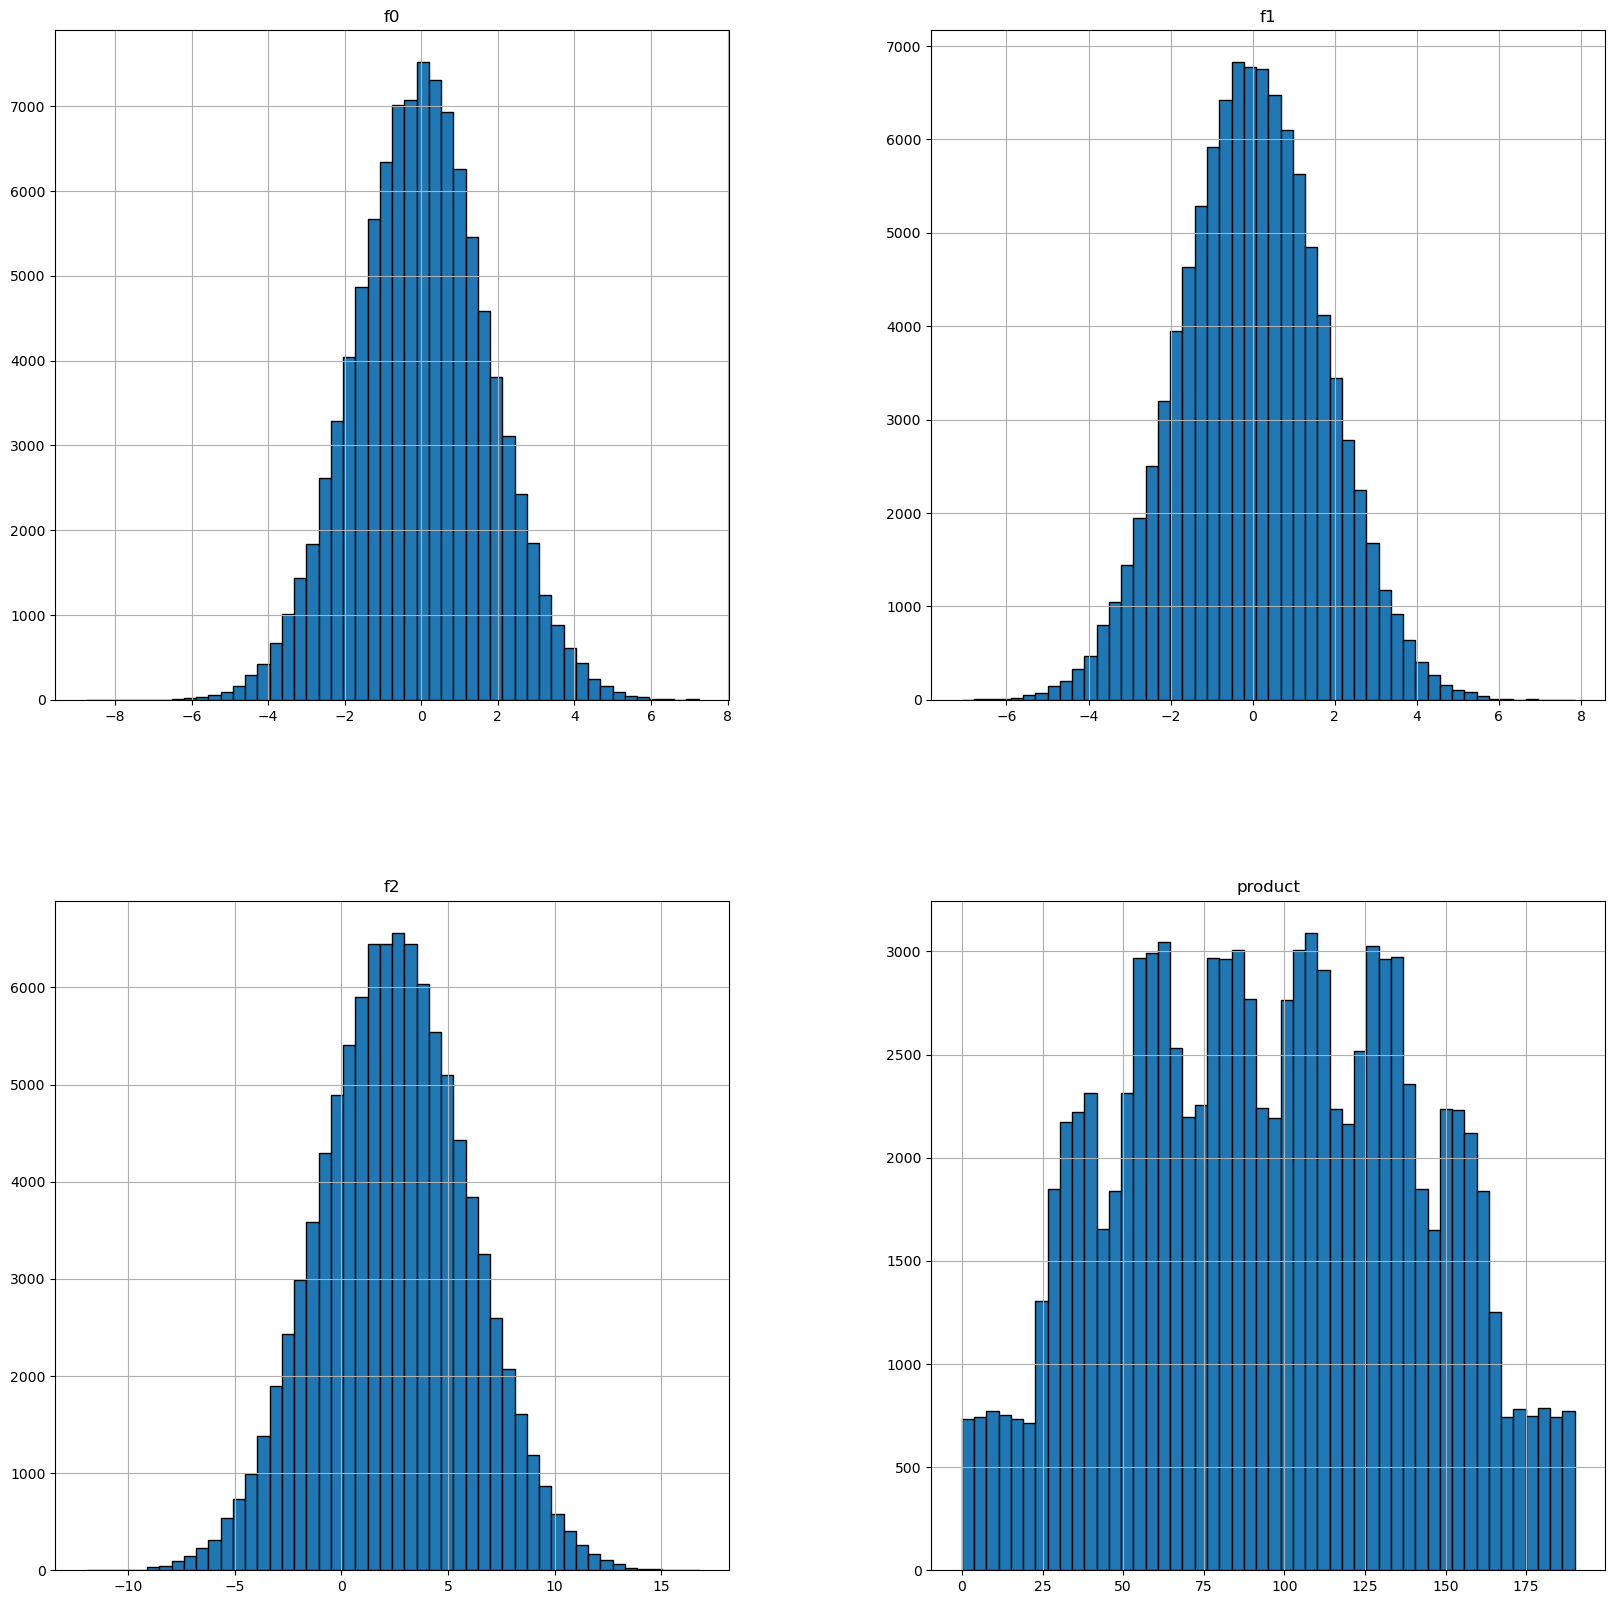

In [156]:
reg_3.hist(bins=50, figsize=(20, 20), edgecolor='black');

В первом датасете данные распределенны нормально, но со всплесками.
Во втором датасете показатели f2 и product имеют странное распределение вокруг малого количества значений.
В третьем датасете распределение нормальное.

In [157]:
df_1 = reg_1.drop('id', axis=1)
df_2 = reg_2.drop('id', axis=1)
df_3 = reg_3.drop('id', axis=1)

Идентификатор скважины не несет полезной информации, его убираем.

In [158]:
print('Корреляция Региона 1:')
print(df_1.corr())
print()
print('Корреляция Региона 2:')
print(df_2.corr())
print()
print('Корреляция Региона 3:')
print(df_3.corr())

Корреляция Региона 1:
               f0        f1        f2   product
f0       1.000000 -0.440723 -0.003153  0.143536
f1      -0.440723  1.000000  0.001724 -0.192356
f2      -0.003153  0.001724  1.000000  0.483663
product  0.143536 -0.192356  0.483663  1.000000

Корреляция Региона 2:
               f0        f1        f2   product
f0       1.000000  0.182287 -0.001777 -0.030491
f1       0.182287  1.000000 -0.002595 -0.010155
f2      -0.001777 -0.002595  1.000000  0.999397
product -0.030491 -0.010155  0.999397  1.000000

Корреляция Региона 3:
               f0        f1        f2   product
f0       1.000000  0.000528 -0.000448 -0.001987
f1       0.000528  1.000000  0.000779 -0.001012
f2      -0.000448  0.000779  1.000000  0.445871
product -0.001987 -0.001012  0.445871  1.000000


Во всех датасетах есть заметная корреляция между признаками f2 и product.
Во втором датасете корреляция равна почти 100%. Вероятно, она появляется из-за анамалии в распределении даннных.

## Обучение и проверка модели

In [159]:
model = LinearRegression()

По условию задачи используем модель линейной регрессии для решения задачи.

In [160]:
def split_data(data, target_column):
    return data.drop(columns=[target_column], axis=1), data[target_column]

Функция для выделения целевого признака

### Проверям 1й регион

In [161]:
features_1, target_1 = split_data(df_1,'product')

In [162]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(features_1, target_1, test_size=.25, random_state=12345)

Разделяем данные на обучающую и тестовую выборки.

In [163]:
X_train_1.shape, X_test_1.shape, y_train_1.shape, y_test_1.shape

((75000, 3), (25000, 3), (75000,), (25000,))

Проверяем полученные данные.

In [164]:
par_grid = {
          'fit_intercept':[True, False], 
          'normalize':[True, False], 
          'copy_X':[True, False]
         }

def report(rep, y, region, pred):
    rep = pd.DataFrame(y)
    rep['predicted'] = pred
    rep['region'] = region
    return rep

Подгатавливаем функции для дальнейшей работы.

In [165]:
model_1 = model.fit(X_train_1, y_train_1)
model_1_predict = model_1.predict(X_test_1)
model_1 = GridSearchCV(model, par_grid, cv=5)
model_1.fit(X_train_1, y_train_1)
predicted_prod_1 = model_1.predict(X_test_1)

Выделяем лучшую модель и получаем результат.

In [166]:
reg_1_report = []
reg_1_report = report(reg_1_report, y_test_1, 1, predicted_prod_1)
reg_1_report.head()

,product,predicted,region
71751,10.038645,95.894952,1
80493,114.551489,77.572583,1
2655,132.603635,77.892640,1
53233,169.072125,90.175134,1
91141,122.325180,70.510088,1


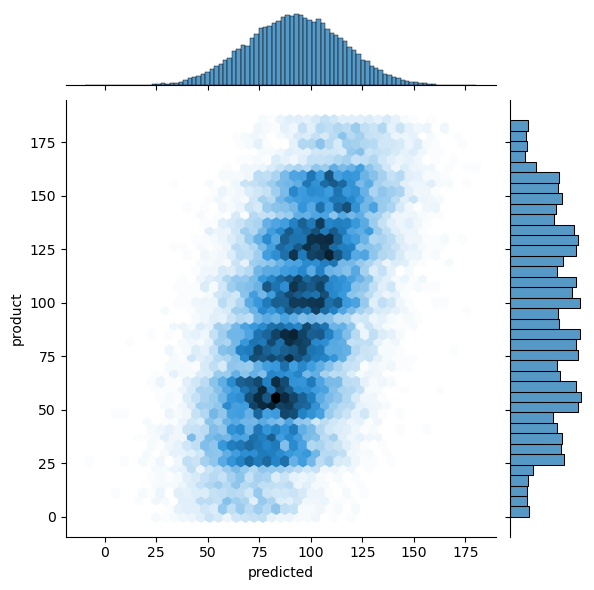

In [167]:
sns.jointplot(x='predicted', y='product', data=reg_1_report, kind='hex');

In [168]:
print('Средние запасы по региону:', reg_1_report['predicted'].mean())
print('MSE модели:', mean_squared_error(y_test_1, predicted_prod_1))
print('RMSE модели:', np.sqrt(mean_squared_error(y_test_1, predicted_prod_1)))
print('MAE модели:', (mean_absolute_error(y_test_1, predicted_prod_1)))
print('Коэффициент детерминации R2', r2_score(y_test_1, predicted_prod_1))

Средние запасы по региону: 92.59256778438008
MSE модели: 1412.2129364399243
RMSE модели: 37.5794217150813
MAE модели: 30.919600777151313
Коэффициент детерминации R2 0.27994321524487786


Вывод:

- В среднем модель предсказывает 92600 баррелей нефти по первому региону
- Среднеквадратичная ошибка прогноза - 1412
- Квадратный корень из среднеквадратичной ошибки - 37.57
- Средняя абсолютная ошибка для первого региона - 30.91
- R2 - 0.28

### Проверяем 2й регион

(75000, 3) (25000, 3) (75000,) (25000,)
Средние запасы по региону: 68.7285468954458
MSE модели: 0.7976263360391153
RMSE модели: 0.8930992867756167
MAE модели: 0.7187662442124757
Коэффициент детерминации R2 0.9996233978805127


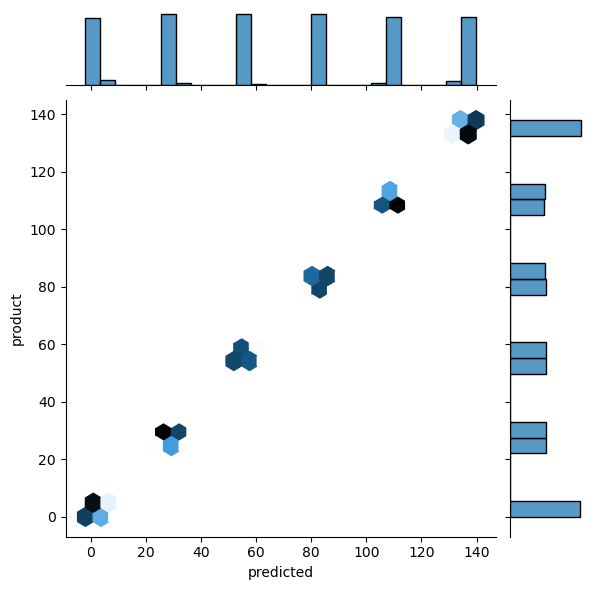

In [169]:
features_2, target_2 = split_data(df_2,'product')
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(features_2, target_2, test_size=.25, random_state=12345)
print(X_train_2.shape, X_test_2.shape, y_train_2.shape, y_test_2.shape)

model_2 = model.fit(X_train_2, y_train_2)
model_2_predict = model_2.predict(X_test_2)
model_2 = GridSearchCV(model, par_grid, cv=5)
model_2.fit(X_train_2, y_train_2)
predicted_prod_2 = model_2.predict(X_test_2)

reg_2_report = []
reg_2_report = report(reg_2_report, y_test_2, 2, predicted_prod_2)
reg_2_report.head()

sns.jointplot(x='predicted', y='product', data=reg_2_report, kind='hex');

print('Средние запасы по региону:', reg_2_report['predicted'].mean())
print('MSE модели:', mean_squared_error(y_test_2, predicted_prod_2))
print('RMSE модели:', np.sqrt(mean_squared_error(y_test_2, predicted_prod_2)))
print('MAE модели:', (mean_absolute_error(y_test_2, predicted_prod_2)))
print('Коэффициент детерминации R2', r2_score(y_test_2, predicted_prod_2))

Вывод:

- В среднем модель предсказывает 68728 баррелей нефти по первому региону
- Среднеквадратичная ошибка прогноза - 0.8
- Квадратный корень из среднеквадратичной ошибки - 0.89
- Средняя абсолютная ошибка для первого региона - 0.72
- R2 - ~1

(75000, 3) (25000, 3) (75000,) (25000,)
Средние запасы по региону: 94.96504596800506
MSE модели: 1602.3775813236196
RMSE модели: 40.02970873393434
MAE модели: 32.792652105481814
Коэффициент детерминации R2 0.20524758386040443


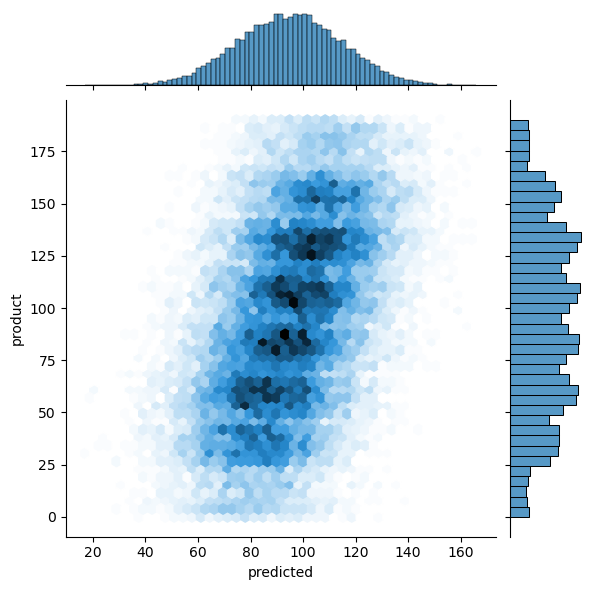

In [170]:
features_3, target_3 = split_data(df_3,'product')
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(features_3, target_3, test_size=.25, random_state=12345)
print(X_train_3.shape, X_test_3.shape, y_train_3.shape, y_test_3.shape)

model_3 = model.fit(X_train_3, y_train_3)
model_3_predict = model_3.predict(X_test_3)
model_3 = GridSearchCV(model, par_grid, cv=5)
model_3.fit(X_train_3, y_train_3)
predicted_prod_3 = model_3.predict(X_test_3)

reg_3_report = []
reg_3_report = report(reg_3_report, y_test_3, 3, predicted_prod_3)
reg_3_report.head()

sns.jointplot(x='predicted', y='product', data=reg_3_report, kind='hex');

print('Средние запасы по региону:', reg_3_report['predicted'].mean())
print('MSE модели:', mean_squared_error(y_test_3, predicted_prod_3))
print('RMSE модели:', np.sqrt(mean_squared_error(y_test_3, predicted_prod_3)))
print('MAE модели:', (mean_absolute_error(y_test_3, predicted_prod_3)))
print('Коэффициент детерминации R2', r2_score(y_test_3, predicted_prod_3))

Вывод:

- В среднем модель предсказывает 94965 баррелей нефти по первому региону
- Среднеквадратичная ошибка прогноза - 1602
- Квадратный корень из среднеквадратичной ошибки - 40.03
- Средняя абсолютная ошибка для первого региона - 32.8
- R2 - 0.2

#### Первый регион
- В среднем модель предсказывает 92600 баррелей нефти по первому региону
- Среднеквадратичная ошибка прогноза - 1412
- Квадратный корень из среднеквадратичной ошибки - 37.57
- Средняя абсолютная ошибка для первого региона - 30.91
- R2 - 0.28

#### Второй регион
- В среднем модель предсказывает 68728 баррелей нефти по первому региону
- Среднеквадратичная ошибка прогноза - 0.8
- Квадратный корень из среднеквадратичной ошибки - 0.89
- Средняя абсолютная ошибка для первого региона - 0.72
- R2 - ~1

#### Третий регион
- В среднем модель предсказывает 94965 баррелей нефти по первому региону
- Среднеквадратичная ошибка прогноза - 1602
- Квадратный корень из среднеквадратичной ошибки - 40.03
- Средняя абсолютная ошибка для первого региона - 32.8
- R2 - 0.2

#### Общий вывод
- Первый и третий регионы показывают лучшие показатели по потенциальной добыче. 92.6 и 94.9 тыс. барр. соответственно
- В свою очередь первый регион показывает немного меньший показатель добычи, но и меньшие показатели ошибок.
- Третий регион показывает противоположные результаты, большую потенциальную добычу, но и большие откланения.
- Второй регион показывает слишком хорошие показатели откланений, это может быть связано со странным распределением данных. Лучше не делать на них выводы, а изучить вопрос качества собранных данных.

## Подготовка к расчёту прибыли

In [171]:
BUDGET = 10000000000
POINTS_OF_WELL = 200
PRICE_PER_1000B = 450000
WELL_PRICE = int(BUDGET / POINTS_OF_WELL)

Сохраняем ключевые значения для расчетов в отдельных переменных.

In [172]:
oil_deposits = WELL_PRICE / PRICE_PER_1000B

print('Минимальный запас нефти на скважину, тысяч баррелей:', oil_deposits)

Минимальный запас нефти на скважину, тысяч баррелей: 111.11111111111111


Рассчитываем достаточный объём сырья для безубыточной разработки новой скважины.

In [173]:
good_reg_1 = (reg_1_report.query('product >= 111.11').shape[0]) / (reg_1_report.shape[0])
print('Доля безубыточных скважин в регионе:', good_reg_1 * 100, '%')

Доля безубыточных скважин в регионе: 36.244 %


In [174]:
good_reg_2 = (reg_2_report.query('product >= 111.11').shape[0]) / (reg_2_report.shape[0])
print('Доля безубыточных скважин в регионе:', good_reg_2 * 100, '%')

Доля безубыточных скважин в регионе: 16.744 %


In [175]:
good_reg_3 = (reg_3_report.query('product >= 111.11').shape[0]) / (reg_3_report.shape[0])
print('Доля безубыточных скважин в регионе:', good_reg_3 * 100, '%')

Доля безубыточных скважин в регионе: 38.164 %


In [176]:
def income(report):
    top_200 = report.sort_values(by=['predicted'], ascending=False)[:200]
    true_sort_sum = report['product'][top_200.index].sum() 
    return (((true_sort_sum * PRICE_PER_1000B) - BUDGET)/ (10**9))

In [177]:
reg_1_income = income(reg_1_report)
reg_2_income = income(reg_2_report)
reg_3_income = income(reg_3_report)

print('Прогнозируемый моделью доход первого региона, млрд. рублей :', reg_1_income)
print('Прогнозируемый моделью доход второго региона, млрд. рублей :',reg_2_income)
print('Прогнозируемый моделью доход третьего региона, млрд. рублей :', reg_3_income)

Прогнозируемый моделью доход первого региона, млрд. рублей : 3.3208260431398506
Прогнозируемый моделью доход второго региона, млрд. рублей : 2.4150866966815108
Прогнозируемый моделью доход третьего региона, млрд. рублей : 2.7103499635998327


In [178]:
print('Прибыль региона относительно затрат:', reg_1_income*10**9/BUDGET)
print('Прибыль региона относительно затрат:', reg_2_income*10**9/BUDGET)
print('Прибыль региона относительно затрат:', reg_3_income*10**9/BUDGET)

Прибыль региона относительно затрат: 0.33208260431398506
Прибыль региона относительно затрат: 0.2415086696681511
Прибыль региона относительно затрат: 0.27103499635998324


In [179]:
result = pd.DataFrame({'region':[1, 2, 3], 'profit':[reg_1_income, reg_2_income, reg_3_income]})
result['useful'] = result['profit'].apply(lambda x: 'да' if x > 0 else 'нет')
result

,region,profit,useful
0,1,3.320826,да
1,2,2.415087,да
2,3,2.710350,да


## Расчёт прибыли и рисков 

In [180]:
def summary(report):
    values = []
    state = np.random.RandomState(12345) 
    
    for i in range(1000):
        
        probs_subsample = report['predicted'].sample(n=500, replace=True, random_state=state)     
        probs_top = probs_subsample.sort_values(ascending=False)
        cur_top_200 = report['product'][probs_top.index][:200]
        profit = ((PRICE_PER_1000B * cur_top_200.sum()) - BUDGET)/ (10**9)
        values.append(profit)
        
    values = pd.Series(values)
    mean = values.mean()
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    confidence_interval = st.t.interval(0.95, len(values)-1, 
                                        mean, values.sem())
    
    risks_sum = 0
    
    for value in values:
        if value < 0:
            risks_sum += 1
        
    risk = risks_sum / len(values)
        
    print('Средняя выручка:', mean)
    print('2.5%-квантиль:', lower)
    print('97.5%-квантиль:', upper)
    print('95% доверительный интервал: ', confidence_interval)
    print('Риски:', risk)
   

Написали функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.

In [181]:
summary(reg_1_report)

Средняя выручка: 0.396164984802371
2.5%-квантиль: -0.11121554589049526
97.5%-квантиль: 0.9097669415534225
95% доверительный интервал:  (0.3796203151479724, 0.4127096544567696)
Риски: 0.069


Выборка bootstrap показывает доход свыше 379 миллионов рублей. Вероятность оказаться убыточным составляет 6.9%

In [182]:
summary(reg_2_report)

Средняя выручка: 0.4560451057866601
2.5%-квантиль: 0.03382050939898362
97.5%-квантиль: 0.852289453866036
95% доверительный интервал:  (0.4431472486638998, 0.46894296290942034)
Риски: 0.015


Выборка bootstrap показывает доход свыше 443 миллионов рублей. Вероятность оказаться убыточным составляет 1.5%

In [183]:
summary(reg_3_report)

Средняя выручка: 0.4044038665683569
2.5%-квантиль: -0.16335041339560108
97.5%-квантиль: 0.9503595749237995
95% доверительный интервал:  (0.3874457974712805, 0.42136193566543334)
Риски: 0.076


Выборка bootstrap показывает доход свыше 387 миллионов рублей. Вероятность оказаться убыточным составляет 7.6%

# Финальные выводы

Нам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Построили модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализировали возможную прибыль и риски техникой Bootstrap.

- Самая высокая прагнозируемая прибыль была отмечена в регионе 1 и составила 3.3 миллиарда рублей.
- Техника bootstrap показала немного больший доход и риск региона 3 чем региона 1, но она, также, имеет и большие риски.
- Bootstrap показал у региона 2 самый лучший показатель по доходу и рискам, но данные имеют странное распределение и делать на них вывод не является целесообразным. Требуется изучить данные, если будет возможность их актуализации, то потребуется провести исследование повторно для данного региона.

В результате считаю правильным начать работу в регионе 1, так как он имеет большую потенциальную прибыль и меньшие риски относительно региона 3.